In [21]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
#hyper-parameter
batch_size = 128
original_dim = 784 #28*28
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [5]:
#샘플링 함수 만들기
def sampling(args:tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var/2)*epsilon

In [6]:
#인코더 만들기
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var,z], name="encoder")

In [7]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [8]:
#디코더 만들기
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [10]:
#모델 결합
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#손실 함수 정의
kl_loss = -0.5*K.sum(1+z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(kl_loss)/784.)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

"""
functional API에서 add_loss 사용시 그냥 변수 가져와서 쓰는게 가능
"""

In [13]:
#훈련/테스트 세트 분할
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11501568/11490434 [==============================] - 0s 0us/step


In [16]:
x_train.shape

(60000, 784)

In [17]:
#학습
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2529
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2230
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2193
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2167
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2147
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2130
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2115
Epoch 8/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2103
Epoch 9/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2092
Epoch 10/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2083
Epoch 11/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2075
Epoch 12/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2068
Epoch 13/50
469/469 [====

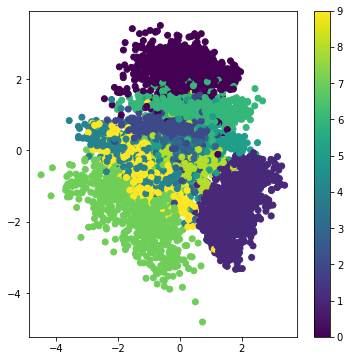

In [20]:
# 잠재 공간 시각화
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

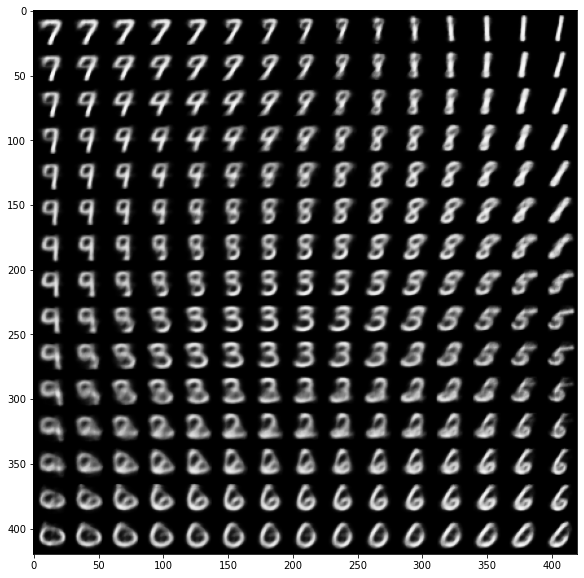

In [23]:
# output 시각화
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size:(i+1)*digit_size,j*digit_size:(j+1)*digit_size] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()